# KMC3-XPP example code

These snippets provide an example for the usage of the kmc3-functions module. 
It is only a code skeleton for reading in data from an exported .h5 file and plotting the resulting reciprocal space maps.
The main development of the data analysis is carried out by the beamline kmc3-xpp team who aim to move to NeXus files. 

In [1]:
# initialize the relevant modules
import os
import matplotlib.pyplot as plt

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import lmfit as lm

import udkm.kmc3.functions as xpp
import udkm.tools.functions as tools
import udkm.tools.colors as colors
plt.style.use("../../../udkm/tools/udkm_base.mplstyle")
example_data_path='../../../udkm/kmc3/example/'
os.chdir(example_data_path)

## temperature series
Minimal working example for a series of identical recicprocal space scans at different temperatures from a .h5 file
- step 1: import data into dictionary and fit model
- step 2: overview plot of rsms and fit result
- step 3: display fit results 

###  (1) loading the data and fitting the peaks
importing the  and fitting with a simple gaussian + background

In [2]:
# %% setting the parameters
folder_name = "temperature_series_333"

scan_list = np.arange(1196, 1295, 1)
scan_list = np.delete(scan_list, [12, 13, 36, 37])
scan_list = scan_list[48:]
h5_file_name = 'au_mgo_333_static_temp_scans1196_1294_2.h5'

plot_log = False
plot_title = "temperature series Au (333)"

qx_min = -0.15
qx_max = 0.15
qx_ticks = np.arange(-0.1, 0.11, 0.1)

qz_min = 7.83
qz_max = 7.919
qz_ticks = np.arange(7.84, 7.93, 0.02)

# initialization of an lmfit model
model = lm.models.GaussianModel() + lm.models.LinearModel()
parameters_qz = lm.Parameters()
parameters_qz.add_many(('center', 7.9, True, qz_min, qz_max),
                       ('sigma', 0.005, True, 0),
                       ('amplitude', 10000, True, 0),
                       ('slope', 0, False),
                       ('intercept', 0, True))

parameters_qx = lm.Parameters()
parameters_qx.add_many(('center', 0, True, qx_min, qx_max),
                       ('sigma', 0.01, True, 0),
                       ('amplitude', 1000, True, 0),
                       ('slope', 0, False),
                       ('intercept', 0, True))


# loading the data into a dictionary takes place from here on
series = xpp.initialize_series()
series["folder_name"] = folder_name
series["title"] = plot_title
ref_index = 0

for i, scan_number in enumerate(scan_list):

    scan_data = xpp.get_q_data(h5_file_name, scan_list[i])
    series = xpp.append_scan(series, scan_data, scan_number)
    series = xpp.fit_scan_qz(series, model, parameters_qz, i)
    series = xpp.fit_scan_qx(series, model, parameters_qx, i)

i_ref = tools.find(series["temperature"], np.min(series["temperature"]))
series = xpp.calc_changes_qz(series, i_ref)
series = xpp.calc_changes_qx(series, i_ref)


### (2) overview plots of the reciprocal spacemaps

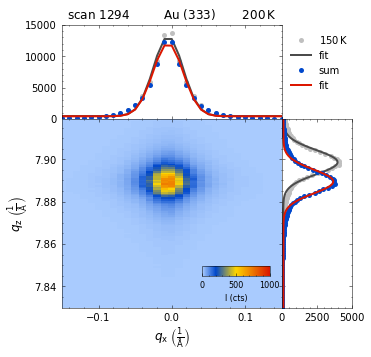

In [3]:
series["c_min_lin"] = 0
series["c_max_lin"] = 1000
for i in [10]:
    # for i, scan_number in enumerate(scan_list):  # <-- use if you want to plot all scans
    f, ax0, ax1, ax2 = xpp.plot_rsm_overview(series, i, plot_log, i_ref)
    
    ax0.set_title("scan " + str(scan_number) + "         Au (333)       "
              + str(int(np.round(series['temperature'][i], 0))) + r"$\,$K")
    
    ax0.set_ylim(0, 15000)
    ax2.set_xlim(0, 5000)
    for ax in [ax0, ax1]:
        ax.set_xticks(qx_ticks)
        ax.set_xlim(qx_min, qx_max)

    for ax in [ax2, ax1]:
        ax.set_yticks(qz_ticks)
        ax.set_ylim(qz_min, qz_max)
    plt.show()

### (3) plotting the extracted results

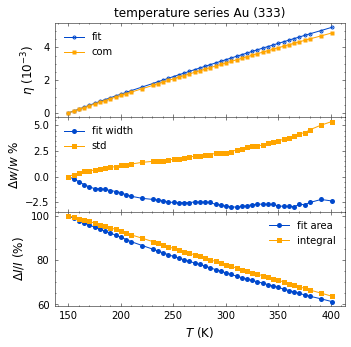

In [4]:
f = plt.figure(figsize=(5.2, 5.2))
gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[1, 1, 1], wspace=0.0, hspace=0.0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1.plot(series["temperature"], series["qz_strain_fit"], '-o', label="fit", ms=1)
ax1.plot(series["temperature"], series["qz_strain_com"], '-s', label="com", ms=1)

ax2.plot(series["temperature"], series["qz_width_change_fit"], '-o', label="fit width")
ax2.plot(series["temperature"], series["qz_width_change_com"], '-s', label="std")

ax3.plot(series["temperature"], series["qz_area_change_fit"]+100, '-o', label="fit area")
ax3.plot(series["temperature"], series["qz_area_change_com"]+100, '-s', label="integral")



ax1.set_ylabel(r'$\eta \,\,\mathrm{\left(10^{-3}\right)}$')
ax2.set_ylabel(r'$\Delta w/w \,\,\mathrm{\% }$')
ax3.set_ylabel(r'$\Delta I/I \,\,\mathrm{(\%)}$')
ax3.set_xlabel(r'$T \,\,\mathrm{\left(K\right)}$')

ax1.set_title(series["title"])
for ax in [ax1, ax2, ax3]:
    ax.legend(loc=0)

# <-- uncomment if you want to save the figure
# plt.savefig(series["folder_name"] + '/overiew_analysis.png')

plt.show()

# <-- uncomment if you want to export the dictionary
#del series["fit_qz"]
#del series["fit_qx"]
#tools.save_dictionary(series, "analysis_results/" + folder_name + ".pickle")


## delay series
Minimal working example for a series of identical recicprocal space scans at different delays from a .h5 file
- step 1: import data into dictionary and fit model
- step 2: overview plot of rsms and fit result
- step 3: display fit results 

###  (1) loading the data and fitting the peaks
importing the  and fitting with a simple gaussian + background

In [5]:
folder_name = "delay_series_333_1000mW"


scan_list = np.arange(596, 638, 1)
scan_list = np.delete(scan_list, [0,33])
h5_file_name = 'au_mgo_333_1000mW_175k_scans596_638.h5'

# plot parameters
plot_log = False
plot_title = "delay series Au (333) 1000mW"
title_short = "Au (333) 1000mW"

qx_min = -0.06
qx_max = 0.06
qx_ticks = np.arange(-0.05, 0.06, 0.05)

qz_min = 7.85
qz_max = 7.925
qz_ticks = np.arange(7.84, 7.93, 0.02)

model = lm.models.GaussianModel() + lm.models.LinearModel()
parameters_qz = lm.Parameters()
parameters_qz.add_many(('center', 7.89, True, qz_min, qz_max),
                       ('sigma', 0.005, True, 0),
                       ('amplitude', 1000, True, 0),
                       ('slope', 0, False),
                       ('intercept', 0, True))

parameters_qx = lm.Parameters()
parameters_qx.add_many(('center', 0, True, qx_min, qx_max),
                       ('sigma', 0.01, True, 0),
                       ('amplitude', 100, True, 0),
                       ('slope', 0, False),
                       ('intercept', 0, True))


series = xpp.initialize_series()
series["folder_name"] = folder_name
series["title"] = plot_title

for i, scan_number in enumerate(scan_list):
    scan_data = xpp.get_q_data(h5_file_name, scan_list[i], tau_offset=246.76)
    series = xpp.append_scan(series, scan_data, scan_number)
    series = xpp.fit_scan_qz(series, model, parameters_qz, i)
    series = xpp.fit_scan_qx(series, model, parameters_qx, i)

i_ref = 0
series = xpp.calc_changes_qz(series, i_ref)
series = xpp.calc_changes_qx(series, i_ref)

tools.make_folder(series["folder_name"])
tools.make_folder(series["folder_name"] + "/rsm_plots")



### (2) overview plots of the reciprocal spacemaps

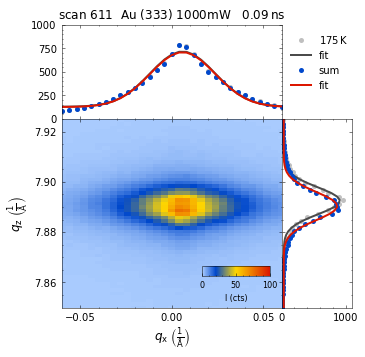

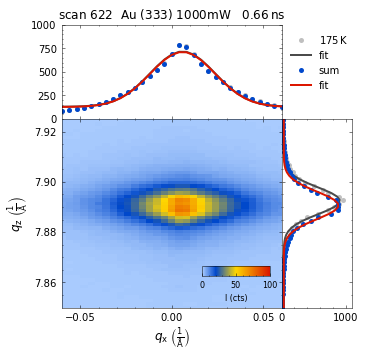

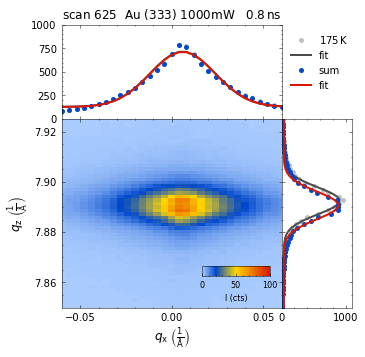

In [6]:
# plot parameters
plot_log = False
series["c_min_lin"] = 0
series["c_max_lin"] = 100

qx_min = -0.06
qx_max = 0.06
qx_ticks = np.arange(-0.05, 0.06, 0.05)

qz_min = 7.85
qz_max = 7.925
qz_ticks = np.arange(7.84, 7.93, 0.02)

for i in [14, 25, 28]:
#for i, scan_number in enumerate(scan_list): # <-- use if you want to plot all scans
    f, ax0, ax1, ax2 = xpp.plot_rsm_overview(series, i, plot_log, i_ref)
    
   
    ax0.set_ylim(0, 1000)
    ax2.set_xlim(0, 1100)
    
    for ax in [ax0, ax1]:
        ax.set_xticks(qx_ticks)
        ax.set_xlim(qx_min, qx_max)

    for ax in [ax2, ax1]:
        ax.set_yticks(qz_ticks)
        ax.set_ylim(qz_min, qz_max)

    ax0.legend(bbox_to_anchor=(1, 1), loc="upper left")
    ax0.set_title("scan " + str(series["scan"][i]) + "  " + title_short + "   "
                  + str(np.round(series['delay'][i], 2)) + r"$\,$ns")


    # plt.savefig(series["folder_name"] + '/rsm_plots/rsm_q' +
    #            tools.timestring(scan_number)+'.png', dpi=200, bbox_inches="tight")
    plt.show()

### (3) plotting the extracted results

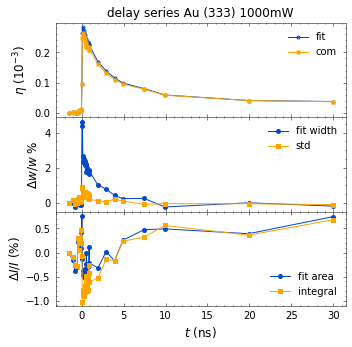

In [7]:
f = plt.figure(figsize=(5.2, 5.2))
gs = gridspec.GridSpec(3, 1, width_ratios=[1], height_ratios=[1, 1, 1], wspace=0.0, hspace=0.0)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

ax1.plot(series["delay"], series["qz_strain_fit"], '-o', label="fit", ms=1)
ax1.plot(series["delay"], series["qz_strain_com"], '-s', label="com", ms=1)

ax2.plot(series["delay"], series["qz_width_change_fit"], '-o', label="fit width")
ax2.plot(series["delay"], series["qz_width_change_com"], '-s', label="std")

ax3.plot(series["delay"], series["qz_area_change_fit"], '-o', label="fit area")
ax3.plot(series["delay"], series["qz_area_change_com"], '-s', label="integral")

ax1.set_ylabel(r'$\eta \,\,\mathrm{\left(10^{-3}\right)}$')
ax2.set_ylabel(r'$\Delta w/w \,\,\mathrm{\% }$')
ax3.set_ylabel(r'$\Delta I/I \,\,\mathrm{(\%)}$')
ax3.set_xlabel(r'$t \,\,\mathrm{\left(ns\right)}$')

ax1.set_title(series["title"])
for ax in [ax1, ax2, ax3]:
    ax.legend(loc=0)
    
# <-- uncomment if you want to save the figure
# plt.savefig(series["folder_name"] + '/overiew_analysis.png')

# <-- uncomment if you want to export the dictionary
#del series["fit_qz"]
#del series["fit_qx"]
#tools.save_dictionary(series, "analysis_results/" + folder_name + ".pickle")